<a href="https://colab.research.google.com/github/Apondi-Otieno/1minOfFame/blob/main/ADtutorial%26QnA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Anomaly Detection with PyOD and ADbench

*Written by Joshua Harvey, for Prospect 33, 2024.*

Anomaly detection involves identifying observations that deviate significantly from the norm. It is a key component of data quality processes (DQ), along with missing value imputation and data drift.

PyOD is a comprehensive library for detecting outliers in multivariate data. It provides various algorithms and utilities for anomaly detection.

ADbench is a set of benchmark datasets pooled from a large number of published papers and previously used open-source datasets. For this notebook, we are only using the ADbench datasets, so these can be downloaded separately if you have issues with installing ADbench (eg dependency clashes).

Shap is a library for implementing the SHAP (Shapley Additive exPlanations) explainability framework. It provides both model-specific and model-agnostic approaches for ML explainability.


## 1. Setup and Installation
Let's start by installing the required libraries. It is strongly recommended to build inside a dedicated environment.

In [2]:
%pip install pyod adbench matplotlib seaborn shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.8/118.8 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)


We also need to download the datasets for ADbench

In [3]:
from adbench.myutils import Utils
utils = Utils() # utility function
# download datasets from the remote github repo
utils.download_datasets(repo='github')

if there is any question while downloading datasets, we suggest you to download it from the website:
https://github.com/Minqi824/ADBench/tree/main/adbench/datasets
如果您在中国大陆地区，请使用链接：
https://jihulab.com/BraudoCC/ADBench_datasets/


  0%|          | 0/3 [00:00<?, ?it/s]

Current saving path: /usr/local/lib/python3.10/dist-packages/adbench/datasets/CV_by_ResNet18


 33%|███▎      | 1/3 [00:43<01:27, 43.54s/it]

Current saving path: /usr/local/lib/python3.10/dist-packages/adbench/datasets/NLP_by_BERT


 67%|██████▋   | 2/3 [00:56<00:25, 25.79s/it]

Current saving path: /usr/local/lib/python3.10/dist-packages/adbench/datasets/Classical


100%|██████████| 3/3 [01:14<00:00, 24.86s/it]


## 2. Load and Explore an ADbench Dataset

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyod.models.knn import KNN  # Example anomaly detector
import shap  # For SHAP values explanation

In [5]:
# Load a dataset from ADbench
adbench_dir = '/usr/local/lib/python3.10/dist-packages/adbench/datasets/Classical/' # change this to your adbench directory
dataset_name = '2_annthyroid.npz'  # You can change this to another dataset, see https://github.com/Minqi824/ADBench/tree/main/adbench/datasets/Classical
data = np.load(adbench_dir+dataset_name, allow_pickle=True)
X, y = data['X'], data['y']

In [6]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Dataset: {dataset_name}")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Dataset: 2_annthyroid.npz
Training set shape: (5040, 6)
Test set shape: (2160, 6)


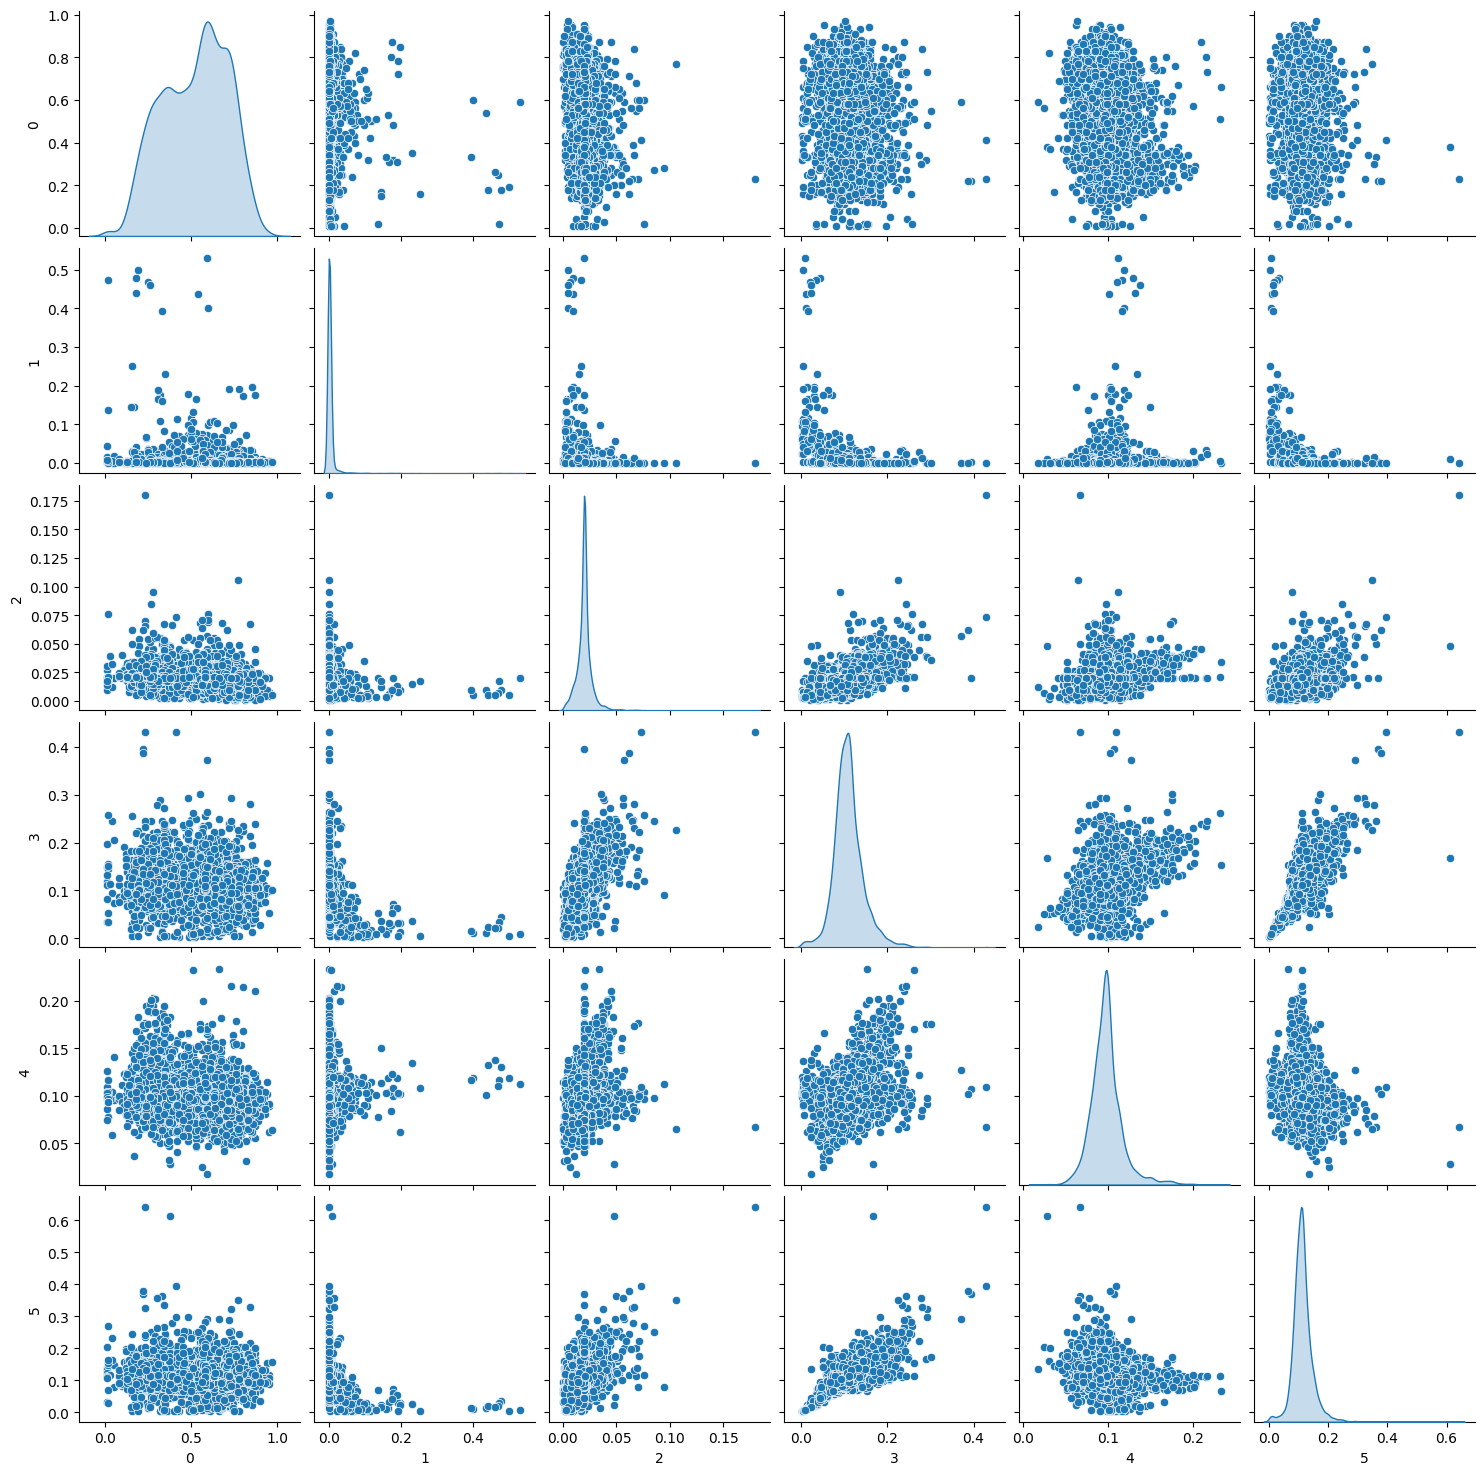

In [7]:
# Visualize the data distribution (use a subset if too large)
sns.pairplot(pd.DataFrame(X_train), diag_kind='kde')
plt.show()

## 3. Using PyOD for Anomaly Detection


In [8]:
# Initialize a PyOD model (KNN as an example)
clf = KNN()

# Train the model
clf.fit(X_train)

# Predict anomalies on the test set
y_test_pred = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)

## 4. Evaluating Anomaly Detection Model Performance

In [9]:
from sklearn.metrics import roc_auc_score, accuracy_score

# Evaluate the model
auc = roc_auc_score(y_test, y_test_scores)
accuracy = accuracy_score(y_test, y_test_pred)

print(f"ROC AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")

ROC AUC: 0.7522
Accuracy: 0.8861


## 5. Visualizing Results

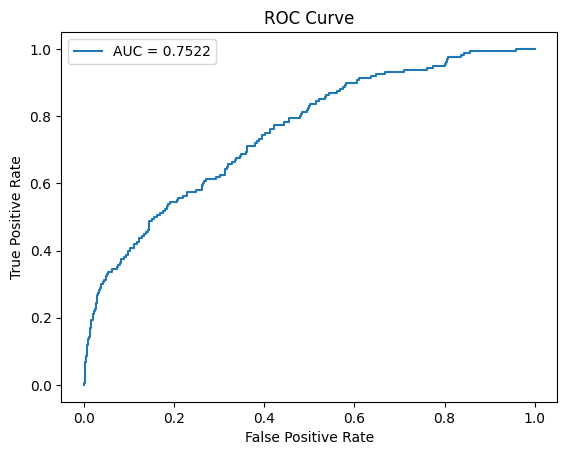

In [10]:
# Plot ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_test_scores)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

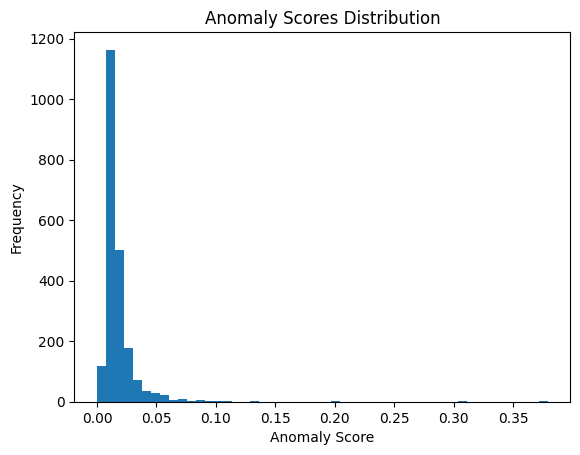

In [11]:
# Visualize anomaly scores
plt.hist(y_test_scores, bins=50)
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Anomaly Scores Distribution')
plt.show()

In [12]:
# Visualize the data distribution (use a subset if too large), coloring true positives, false positives, true negatives, and false negatives
df = pd.DataFrame(X_train)
df['y'] = y_train
df['y_pred'] = clf.predict(X_train)


In [13]:
def label_outcome(row):
    if row['y'] == 1 and row['y_pred'] == 1:
        return 'TP'  # True Positive
    elif row['y'] == 0 and row['y_pred'] == 1:
        return 'FP'  # False Positive
    elif row['y'] == 0 and row['y_pred'] == 0:
        return 'TN'  # True Negative
    elif row['y'] == 1 and row['y_pred'] == 0:
        return 'FN'  # False Negative


In [14]:
# Re-add the 'y' and 'y_pred' columns to the DataFrame before applying the function
df['y'] = y_train
df['y_pred'] = clf.predict(X_train)

df['outcome'] = df.apply(label_outcome, axis=1)
df = df.drop(['y', 'y_pred'], axis=1) # Now you can safely drop the columns
df.head()

0        1      2      3      4      5 outcome
0  0.28  0.00208  0.017  0.116  0.101  0.115      TN
1  0.74  0.00300  0.012  0.096  0.093  0.103      TN
2  0.85  0.00140  0.006  0.124  0.096  0.129      TN
3  0.34  0.00680  0.024  0.096  0.104  0.090      FN
4  0.46  0.00091  0.024  0.124  0.104  0.118      TN

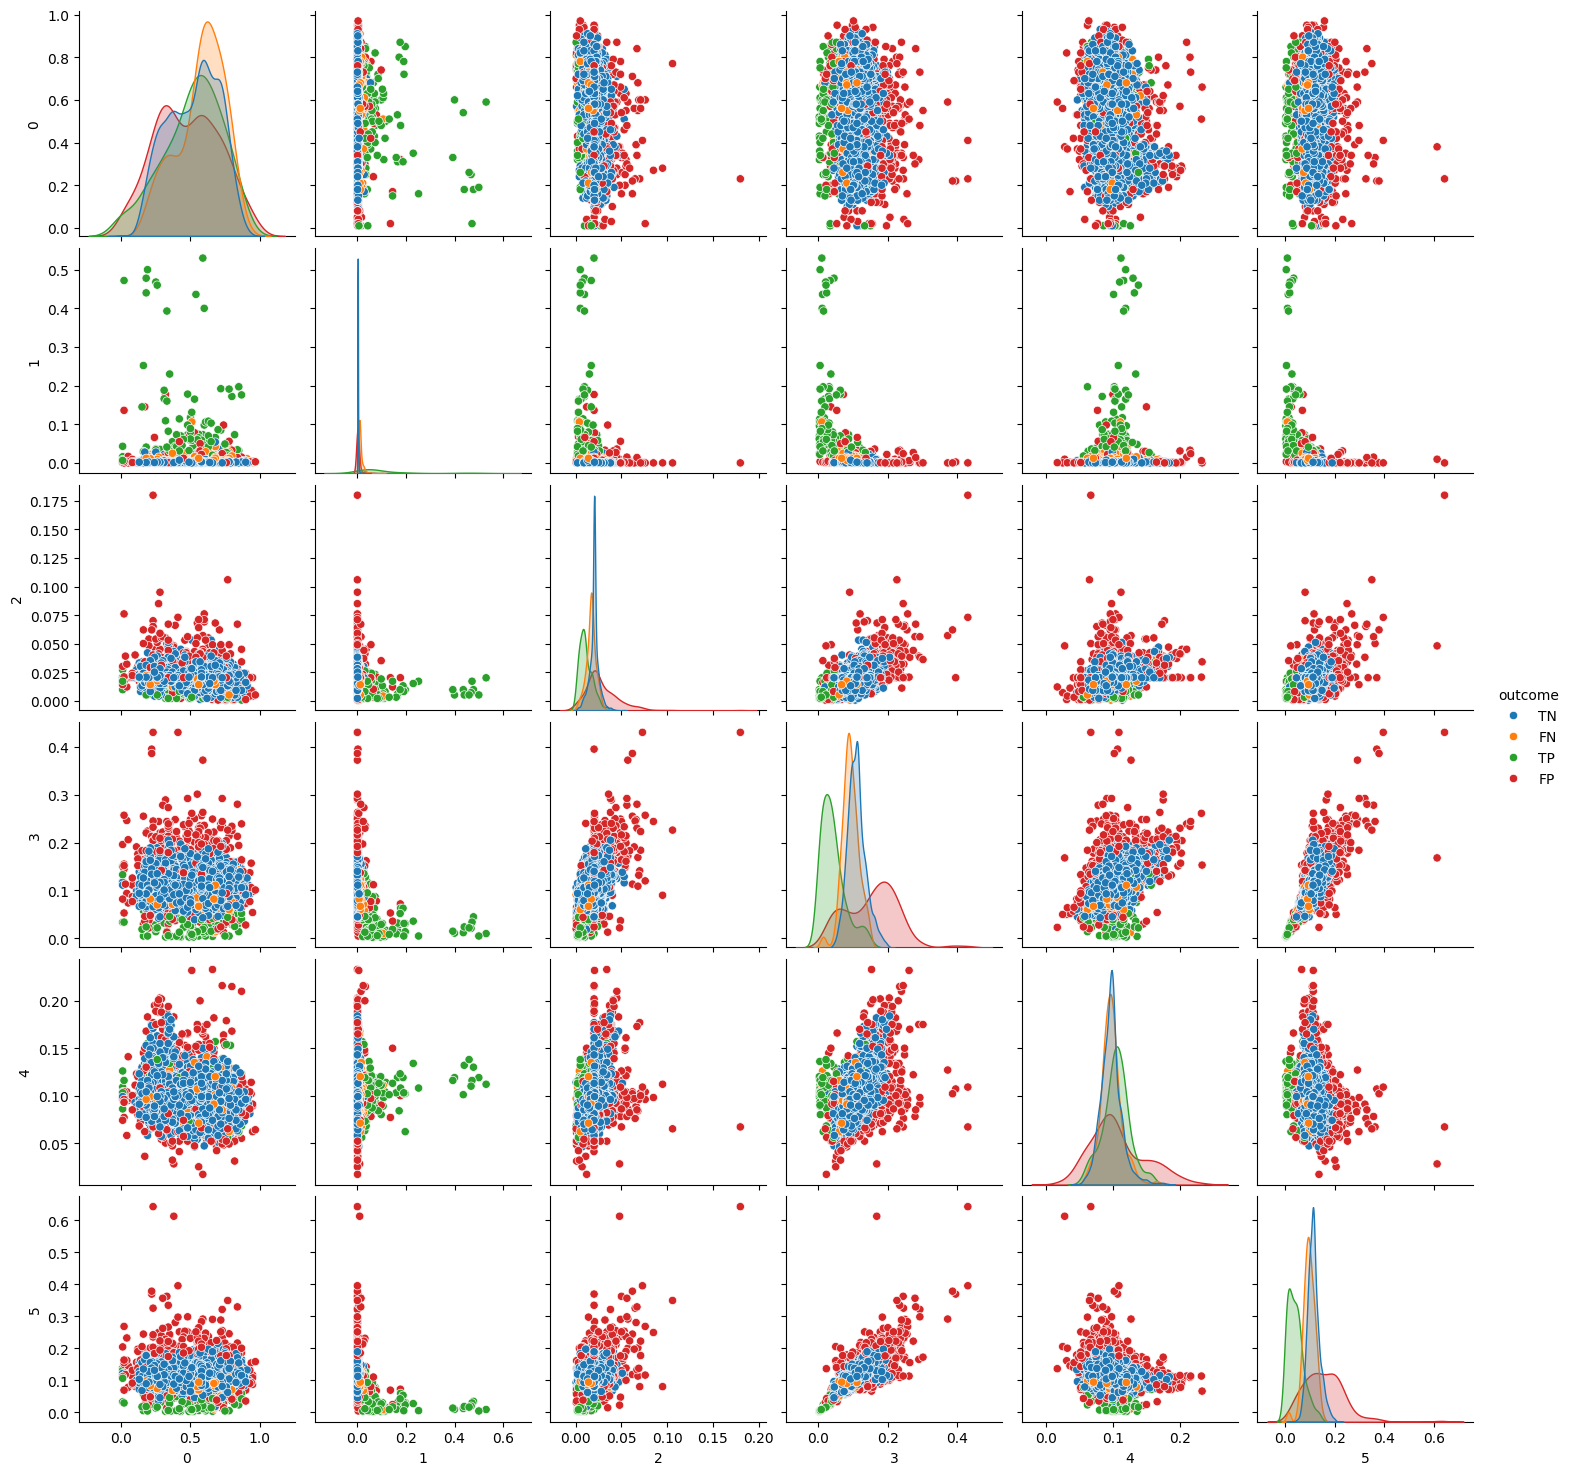

In [15]:
# Visualize the data distribution (use a subset if too large), coloring true positives, false positives, true negatives, and false negatives

pp = sns.pairplot(df, diag_kind='kde', hue='outcome',  # color by outcome
                  diag_kws=dict(common_norm=False))  # scale kde independently for each outcome
plt.show()

## 6. Explainability with SHAP

In [16]:
# find index of first true positive
first_tp_index = df[df['outcome'] == 'TP'].index[0]
print(f"Index of the first True Positive: {first_tp_index}")

Index of the first True Positive: 20


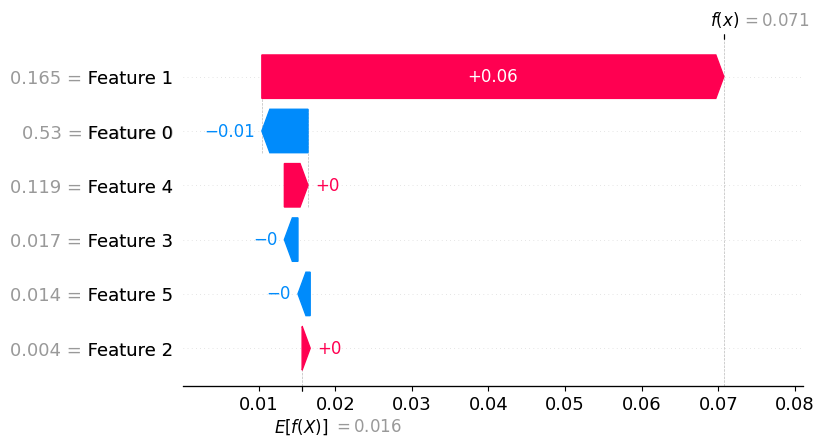

In [17]:
# Fit SHAP explainer and obtain SHAP values for one observation -- TRUE POSITIVE
explainer = shap.explainers.Exact(clf.decision_function, X_train)
shap_values_exact = explainer(np.array([X_train[first_tp_index,]]))
shap.plots.waterfall(shap_values_exact[0])

# Internal GDL project

## *1. How do different unsupervised anomaly detectors perform across different datasets?*
Limit research to unsupervised anomaly detectors, on the following ADbench datasets:
* annthyroid,
* campaign,
* census,
* donors, and
* skin

Evaluate performance of AD methods using AUC-ROC. Keep in mind different methods have different hyperparameters. Optimizing hyperparameters requires cross-validation.

### Hints

*You may want to subsample datasets to reduce computational load---make sure to stratify on y to preserve class balance of inliers/outliers.*

*While you can run each dataset as a single experiment, it may be more efficient to build a pipeline.*

## *2. How consistent are SHAP explanations for different anomaly detectors?*
Where anomaly detectors agree on predictions, do they give rise to similar SHAP value explanations? How about when they disagree?

## *3. How does missing data impact anomaly detection?*
Are different anomaly detection algorithms better suited for datasets where there are more missing values?

# Project Answers

Written & Researched by Apondi Otieno for Week 1 July Project for the GDL.





## Project Pipeline

I worked with the following pipeline to complete the project:

1. Set Up the Environment
2. Build the Pipeline
3. Define the Unsupervised Anomaly
4. Detection Methods
5. Run Evaluations and Pool Results
6. Apply SHAP for Explainability
7. Analyze Sensitivity to Missingness
8. Compare SHAP Explanations
9. Add conclusions.



# Question 1

## Step 1:Load and explore the datasets.

In [18]:
# load the datasets.
adbench_dir = '/usr/local/lib/python3.10/dist-packages/adbench/datasets/Classical/'
dataset_names = ['2_annthyroid.npz', '5_campaign.npz', '9_census.npz', '11_donors.npz', '33_skin.npz']
datasets = [np.load(adbench_dir+dataset_name, allow_pickle=True) for dataset_name in dataset_names]
# iterate over datasets
loaded_datasets = []
for data in datasets:
    X, y = data['X'], data['y']
    loaded_datasets.append((X, y))
# update datasets
datasets=loaded_datasets

In [19]:
# checking if the file path leads to the right place because of the filenotfounderror

import os
print(os.listdir(adbench_dir))


['16_http.npz', '32_shuttle.npz', '8_celeba.npz', '27_PageBlocks.npz', '38_thyroid.npz', '46_WPBC.npz', '11_donors.npz', '30_satellite.npz', '6_cardio.npz', '37_Stamps.npz', '35_SpamBase.npz', '24_mnist.npz', '29_Pima.npz', '19_landsat.npz', '17_InternetAds.npz', '31_satimage-2.npz', '47_yeast.npz', '3_backdoor.npz', '10_cover.npz', '2_annthyroid.npz', '39_vertebral.npz', '20_letter.npz', '34_smtp.npz', '33_skin.npz', '43_WDBC.npz', '23_mammography.npz', '9_census.npz', '28_pendigits.npz', '15_Hepatitis.npz', '41_Waveform.npz', '18_Ionosphere.npz', '42_WBC.npz', '5_campaign.npz', '36_speech.npz', '40_vowels.npz', '25_musk.npz', '1_ALOI.npz', '4_breastw.npz', '26_optdigits.npz', '7_Cardiotocography.npz', '44_Wilt.npz', '22_magic.gamma.npz', '21_Lymphography.npz', '13_fraud.npz', '14_glass.npz', '45_wine.npz', '12_fault.npz']


In [20]:

# splitting the training and testing data sets in all 5 data sets

from sklearn.model_selection import train_test_split

for i, data in enumerate(datasets):
  # i is for index of the datasets in the dictionary(dataset_names)
  # enumerate is a python function used to iterate over an iterable object
    X, y = data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    print(f"Dataset: {dataset_names[i]}")
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")



Dataset: 2_annthyroid.npz
Training set shape: (5040, 6)
Test set shape: (2160, 6)
Dataset: 5_campaign.npz
Training set shape: (28831, 62)
Test set shape: (12357, 62)
Dataset: 9_census.npz
Training set shape: (209499, 500)
Test set shape: (89786, 500)
Dataset: 11_donors.npz
Training set shape: (433528, 10)
Test set shape: (185798, 10)
Dataset: 33_skin.npz
Training set shape: (171539, 3)
Test set shape: (73518, 3)


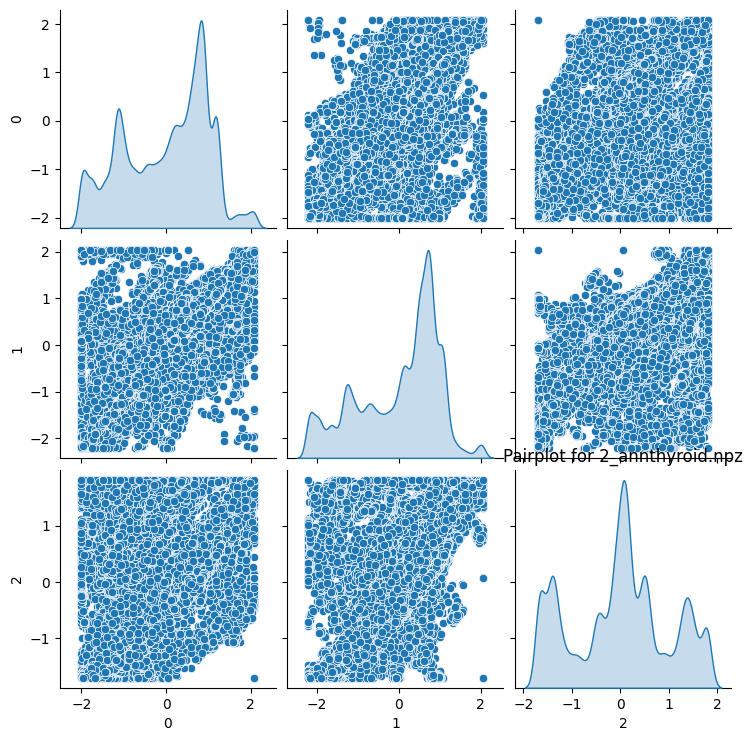

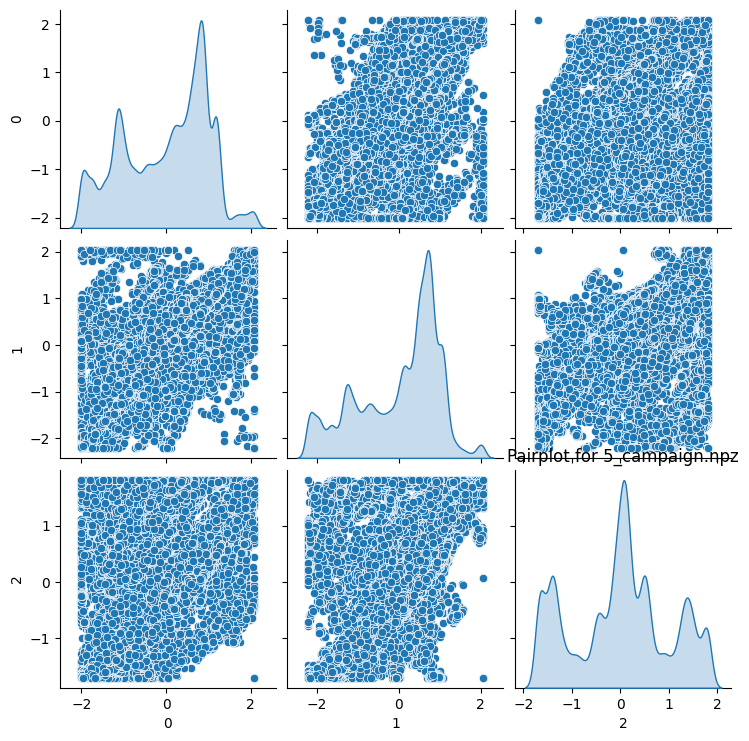

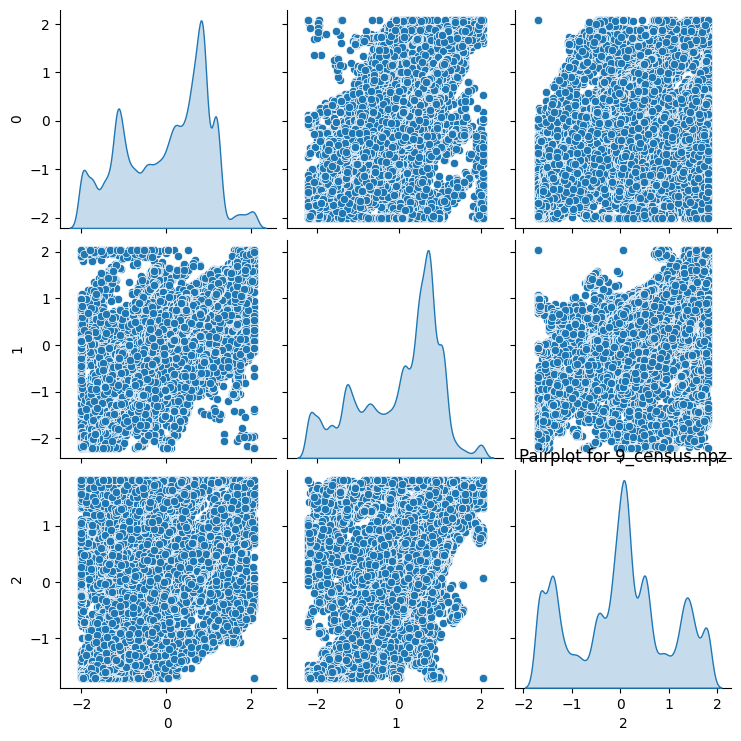

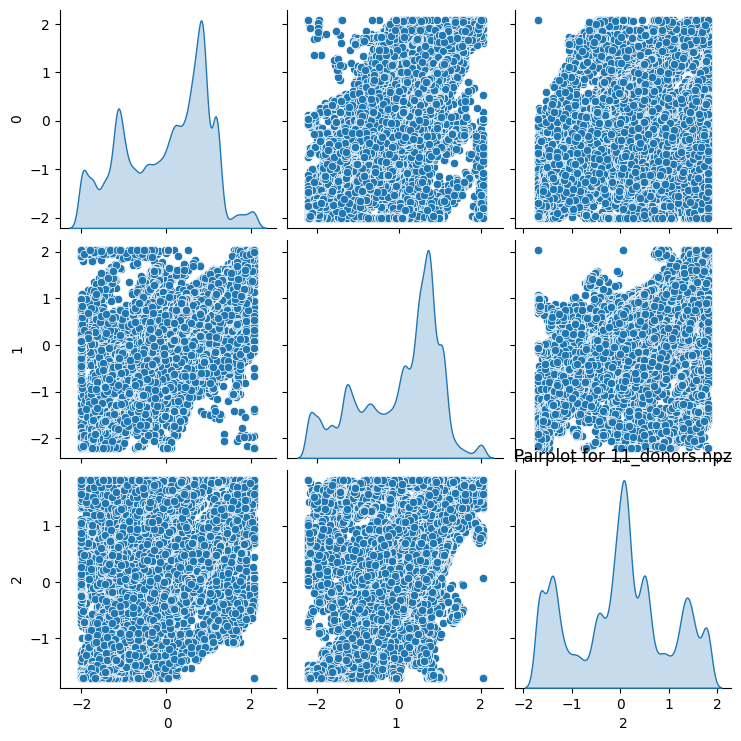

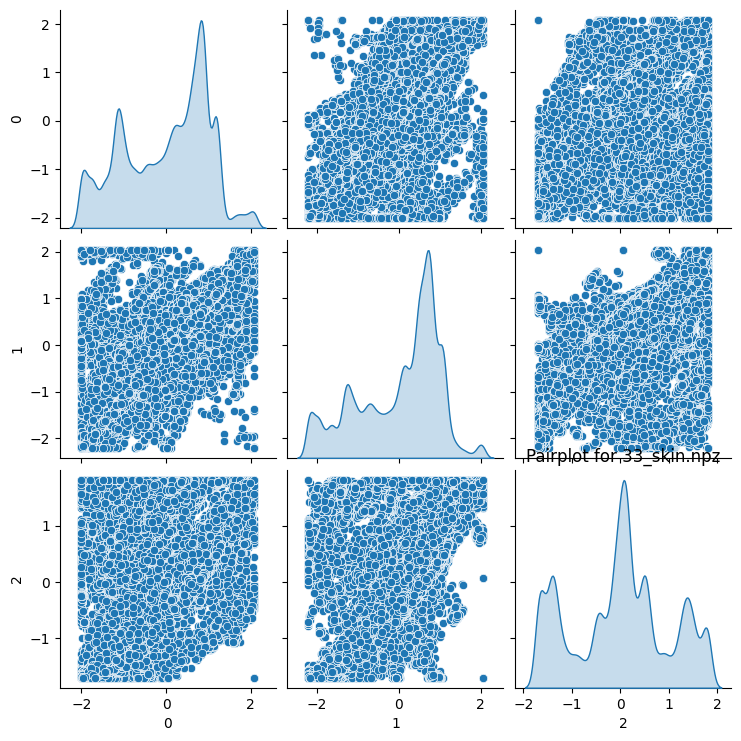

In [21]:
# visualize the training data distribution.
for i in range(len(datasets)):
  sns.pairplot(pd.DataFrame(X_train), diag_kind='kde')
  plt.title(f"Pairplot for {dataset_names[i]}")
  plt.show()

## Step 2:Performance of Unsupervised Anomaly Detectors

In this section i intend to demonstrate the performance of AD methods using AUC-ROC and show overall performance

1. Annthyroid
2. Campaign
3. Census
4. Donors
5. Skin





Dataset: 2_annthyroid.npz
Training set shape: (5040, 6)
Test set shape: (2160, 6)
ROC AUC for dataset 2_annthyroid.npz: 0.7522
Accuracy for dataset 2_annthyroid.npz: 0.8861
------


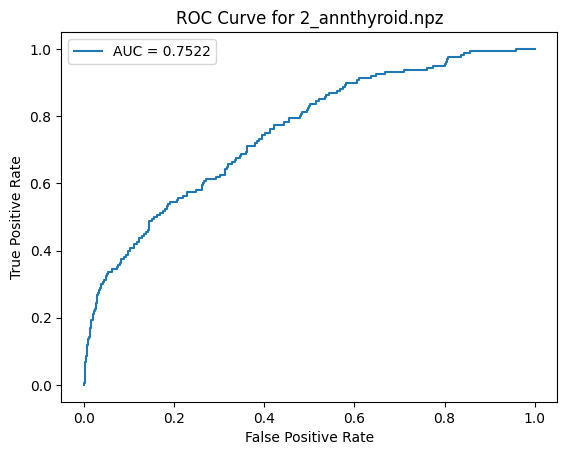

Dataset: 5_campaign.npz
Training set shape: (28831, 62)
Test set shape: (12357, 62)
ROC AUC for dataset 5_campaign.npz: 0.7232
Accuracy for dataset 5_campaign.npz: 0.8343
------


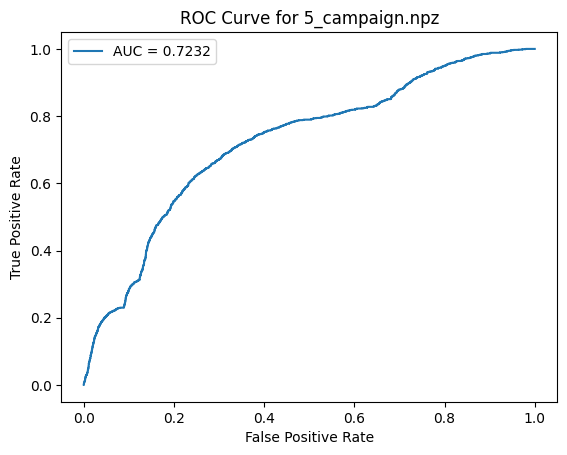

Dataset: 9_census.npz
Training set shape: (209499, 500)
Test set shape: (89786, 500)


KeyboardInterrupt: 

In [22]:
#how do i show overall performance of the AD methods in one pool?

results = {}  # Initialize a dictionary to store results
for i, data in enumerate(datasets):
    X, y = data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    print(f"Dataset: {dataset_names[i]}")
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    # ... (your existing code for model training and evaluation)
    # apply pyOD to detect anomalies.

    # Initialize a PyOD model (KNN as an example)
    clf = KNN()

    # Train the model
    clf.fit(X_train)

    # Predict anomalies on the test set
    y_test_pred = clf.predict(X_test)
    y_test_scores = clf.decision_function(X_test)

    # Evaluate performance of AD methods using AUC-ROC

    from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
    fpr, tpr, thresholds = roc_curve(y_test, y_test_scores)
    auc = roc_auc_score(y_test, y_test_scores)
    accuracy = accuracy_score(y_test, y_test_pred)

    print(f"ROC AUC for dataset {dataset_names[i]}: {auc:.4f}")
    print(f"Accuracy for dataset {dataset_names[i]}: {accuracy:.4f}")
    print("------")  # Add a separator between datasets

    # Store the results
    results[dataset_names[i]] = {'auc': auc, 'accuracy': accuracy}


    #to do:subset the datasets

    # visualize the ROC curve


      # Plot ROC curve
    import matplotlib.pyplot as plt

    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {dataset_names[i]}')
    plt.legend(loc='best')
    plt.show()



## Step 3: Visualize anomaly scores

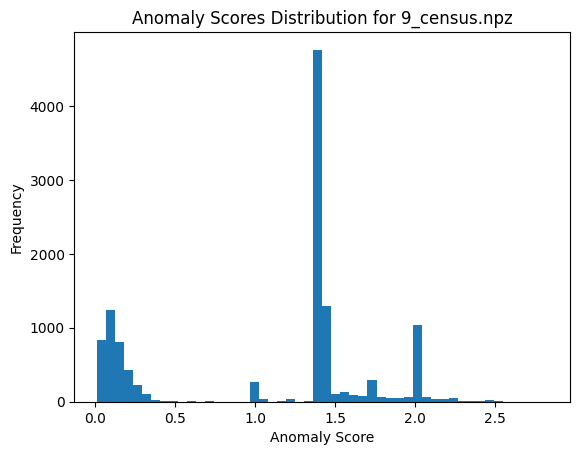

In [23]:
import matplotlib.pyplot as plt

plt.hist(y_test_scores, bins=50)
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title(f'Anomaly Scores Distribution for {dataset_names[i]}')
plt.show()

In [ ]:
#find out how to apply this code to the looped datasets that i have

# Visualize the data distribution (use a subset if too large), coloring true positives, false positives, true negatives, and false negatives
df = pd.DataFrame(X_train)
df['y'] = y_train
df['y_pred'] = clf.predict(X_train)

#then visualize

def label_outcome(row):
    if row['y'] == 1 and row['y_pred'] == 1:
        return 'TP'  # True Positive
    elif row['y'] == 0 and row['y_pred'] == 1:
        return 'FP'  # False Positive
    elif row['y'] == 0 and row['y_pred'] == 0:
        return 'TN'  # True Negative
    elif row['y'] == 1 and row['y_pred'] == 0:
        return 'FN'  # False Negative


# then

# Re-add the 'y' and 'y_pred' columns to the DataFrame before applying the function
df['y'] = y_train
df['y_pred'] = clf.predict(X_train)

df['outcome'] = df.apply(label_outcome, axis=1)
df = df.drop(['y', 'y_pred'], axis=1) # Now you can safely drop the columns
df.head()

# then how can we visualize all the datasets?

# Visualize the data distribution (use a subset if too large), coloring true positives, false positives, true negatives, and false negatives

pp = sns.pairplot(df, diag_kind='kde', hue='outcome',  # color by outcome
                  diag_kws=dict(common_norm=False))  # scale kde independently for each outcome
plt.show()


In [ ]:

# use this as a guide for tp and fp!

def label_outcome(row):
    if row['y'] == 1 and row['y_pred'] == 1:
        return 'TP'  # True Positive
    elif row['y'] == 0 and row['y_pred'] == 1:
        return 'FP'  # False Positive
    elif row['y'] == 0 and row['y_pred'] == 0:
        return 'TN'  # True Negative
    elif row['y'] == 1 and row['y_pred'] == 0:
        return 'FN'  # False Negative

for i, data in enumerate(datasets):
    # ... (your existing code for model training, prediction, and DataFrame creation)

    # Calculate and add outcome column
    df['outcome'] = df.apply(label_outcome, axis=1)

    # ... (rest of your code, including finding the index of the first true positive, if needed)

# Question 2


## Step 1: Explainability with SHAP

## Step 2:Which ones give rise to SHAP explanations that agree, or disagree?

# Question 3


## Step 1:Which unsupervised anomaly detector performs the best?

## Step 2:Which is least sensitive to missingness in the data